In [73]:
"""
This notebook is for showing that GA + RF is better than RF alone in terms of accuracy, sensitivity and specification
and FP rate. 

The GA + RF algorithm has the parameters:
NUM_TREES: 20, 30, 50
IND_SIZE = 10
POP_SIZE = 30
CX_RATE = 0.8
MUTATE_RATE = 1/IND_SIZE

"""



# library for GA
import random

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

# library for RF
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


import pandas as pd
from seaborn import violinplot
import seaborn as sns

In [46]:
# set algorithm parameters

def run_GA(NUM_TREES, IND_SIZE, POP_SIZE, CX_RATE = 0.8):
    """
    NUM_TREES is the number of trees the random forest model pro
    """    
    MUTATE_RATE = 1.0/IND_SIZE 
    
    
    
    # prepare data
    data = pd.read_csv("./data/miro_RNA.csv", sep = ',', header = 0)
    raw = data.values

    X = raw[:, 0:36]
    y = raw[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=random.randint(0,5000))
    
    
    model = RandomForestClassifier(n_estimators= NUM_TREES) # create a random forest with NUM_TREES = 20 
    model.fit(X_train, y_train) # train the model
    estimators = model.estimators_ # get all the trees
    
    # implement individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)
    # implement functions for initialize population and create individual
    toolbox = base.Toolbox() # create a toolbox of operators for our GA algorithm
    toolbox.register("indices", random.sample, range(NUM_TREES), NUM_TREES) # this is a helper function for creating
                                                                            # each individual
    toolbox.register("individual", tools.initIterate, creator.Individual,   # this is the function for creating an 
                     toolbox.indices)                                       # individual


    #toolbox.individual()  # a test 

    # implement function for creating a population
    toolbox.register("population", tools.initRepeat, list, toolbox.individual, n = POP_SIZE)

    #toolbox.population()  # a test
    
    def sub_rf_predict(sub_rf, X_test):
        """
        return the predict result using the sub_rf and X_test data;
        the rule is that predict result(labels) with the maximum number of votes wins.
        """
        predict_results = []
        for tree in sub_rf:
            prediction = tree.predict(X_test)
            # record prediction result for a tree
            predict_results.append(prediction)

        # compute the vote_result, i.e. the final result
        y_predict = [0]*len(X_test)
        for idx in range(len(X_test)):
            # for each test data
            # create a vote result
            v_result = vote_result()
            for predict_tree in predict_results:
                v_result[predict_tree[idx]] += 1

            # final result
            y_predict[idx] = keywithmaxval(v_result)

        return  np.array(y_predict, dtype = float)

    # helper function
    y_set = set(y_test).union(y_train)
    def vote_result():
        result = {}
        for k in y_set:
            result[k] = 0
        return result

    def keywithmaxval(d):
        """ a) create a list of the dict's keys and values; 
        b) return the key with the max value"""  
        v=list(d.values())
        k=list(d.keys())
        return k[v.index(max(v))]
    
    
    def evaluate(individual):
        # return the accuracy on the test data
        sub_random_forest = []
        for tree_idx in individual[0: IND_SIZE]:
            sub_random_forest.append(estimators[tree_idx])

        predict_sub_trees = sub_rf_predict(sub_random_forest, X_test)
        # print(predict_sub_trees.__repr__())
        # score = precision_score(y_test, predict_sub_trees, average = 'macro')
        score = accuracy_score(y_test, predict_sub_trees)
        return  score,  # must return an tuple!!!!
    
    def evaluate_confusion_matrix(individual):
        # return the confusion matrix of a model
        sub_random_forest = []
        for tree_idx in individual[0: IND_SIZE]:
            sub_random_forest.append(estimators[tree_idx])

        predict_sub_trees = sub_rf_predict(sub_random_forest, X_test)
        cf_matrix = confusion_matrix(y_test, predict_sub_trees)
        return  cf_matrix 

    
    
    # implement mutation operator
    mutation_op = tools.mutShuffleIndexes
    
    
    # implement crossover
    def crossover_op(ind1, ind2):
        # only cross over the first IND_SIZE elements in the individual in place
        crossover_idx = random.randint(0, IND_SIZE - 2)
        # print(crossover_idx)
        temp = toolbox.clone(ind1[crossover_idx + 1: IND_SIZE])
        ind1[crossover_idx + 1: IND_SIZE] = ind2[crossover_idx + 1: IND_SIZE]
        ind2[crossover_idx + 1: IND_SIZE] = temp
        return (ind1, ind2)
    
    # implement selection operator
    selection_op = tools.selTournament
    
    
    # register everything in our toolbox
    toolbox.register("mate", crossover_op)
    toolbox.register("mutate", mutation_op, indpb = MUTATE_RATE)
    toolbox.register("select", selection_op, tournsize=3)
    toolbox.register("evaluate", evaluate)
    
    
    h_fame = tools.HallOfFame(100) # keep track of the first 100 best individuals and store them in h_fame

    pop = toolbox.population()
    final_pop = algorithms.eaSimple(pop, toolbox, cxpb = CX_RATE, mutpb=MUTATE_RATE, ngen=1000, 
                                    stats = None, halloffame = h_fame, verbose = False)
    
    # accuracy_of_the_best_individual = evaluate(h_fame[0])
    # accuracy_of_the_whole_trees_model = accuracy_score(y_test, model.predict(X_test))
    cf_matrix_RF_model = confusion_matrix(y_test, model.predict(X_test))
    cf_matrix_GA_RF_model = evaluate_confusion_matrix(h_fame[0])
    
    return cf_matrix_GA_RF_model, cf_matrix_RF_model, evaluate_confusion_matrix, h_fame

In [47]:
def measure_model_performance(C):
    """
    C is a confusion matrix
    accuracy, sensitivity, specificity: the higher the better
    FP_rate: the lower the better
    """
    accuracy = (C[0,0] + C[1, 1]) / np.sum(C)
    TP_rate = C[1, 1] / (C[1, 0] + C[1, 1]) # also called Sensitiviy or Recall. The larger the better. Answers the question: when it's actually yes, how often does it predict yes
    sensitivity = TP_rate
    FP_rate = C[0, 1] / (C[0, 0] + C[0, 1]) # the smaller the better. When it's actually no, how often does it predict yes.
    TN_rate = C[0, 0] / (C[0, 0] + C[0, 1]) # the larger the better. also called specificity. When it's actually no, how often does it predict no.
    specificity = TN_rate
    return accuracy, sensitivity, specificity, FP_rate
    

In [48]:
# run_GA(NUM_TREES, IND_SIZE, POP_SIZE, CX_RATE = 0.8)
# return cf_matrix_GA_RF_model, cf_matrix_RF_model, evaluate_confusion_matrix, h_fame

import warnings; warnings.simplefilter('ignore')

GA_accuracy_final_result = []
RF_accuracy_final_result = []

GA_sensitivity_final_result = []
RF_sensitivity_final_result = []

GA_specificity_final_result = []
RF_specificity_final_result = []

GA_FP_rate_final_result = []
RF_FP_rate_final_result = []

for num_trees in [20, 30, 50]:
    GA_accuracy_result = []
    RF_accuracy_result = []
    
    GA_sensitivity_result = []
    RF_sensitivity_result = []
    
    GA_specificity_result = []
    RF_specificity_result = []
    
    GA_FP_rate_result = []
    RF_FP_rate_result = []
    print('num_trees = ', num_trees)
    for i in range(50):  # run the experiment 50 times
        print(i)
        cf_matrix_GA_RF_model, cf_matrix_RF_model, evaluate_confusion_matrix, h_fame = run_GA(num_trees, 10, 30)
        
        GA_accuracy, GA_sensitivity, GA_specificity, GA_FP_rate = measure_model_performance(cf_matrix_GA_RF_model)
        RF_accuracy, RF_sensitivity, RF_specificity, RF_FP_rate = measure_model_performance(cf_matrix_RF_model)
        
        GA_accuracy_result.append(GA_accuracy)
        RF_accuracy_result.append(RF_accuracy)
        
        GA_sensitivity_result.append(GA_sensitivity)
        RF_sensitivity_result.append(RF_sensitivity)
        
        GA_specificity_result.append(GA_specificity)
        RF_specificity_result.append(RF_specificity)
        
        GA_FP_rate_result.append(GA_FP_rate)
        RF_FP_rate_result.append(RF_FP_rate)
    
    GA_accuracy_final_result.append(GA_accuracy_result)
    RF_accuracy_final_result.append(RF_accuracy_result)
    
    GA_sensitivity_final_result.append(GA_sensitivity_result)
    RF_sensitivity_final_result.append(RF_sensitivity_result)

    GA_specificity_final_result.append(GA_specificity_result)
    RF_specificity_final_result.append(RF_specificity_result)
    
    GA_FP_rate_final_result.append(GA_FP_rate_result)
    RF_FP_rate_final_result.append(RF_FP_rate_result)

num_trees =  20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
num_trees =  30
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
num_trees =  50
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [57]:
def convert_to_df(GA_result, RF_result, result_name):
    # first make the list shallow
    GA_result = sum(GA_result, [])
    RF_result = sum(RF_result, [])
    
    num_trees = 50*[20] + 50*[30] + 50*[50]
    num_trees = num_trees + num_trees
    algorithm = 150 * ['GA + RF'] + 150 * ['RF']l
    data = GA_result + RF_result
    
    # form the dictionary
    d = {result_name:data, 'algorithm': algorithm, 'num_trees': num_trees}
    
    df = pd.DataFrame(data = d)
    return df

In [78]:
pd_accuracy = convert_to_df(GA_accuracy_final_result,RF_accuracy_final_result , 'accuracy')
# save data
pd_accuracy.to_pickle('.\figure_data\fig(1).pkl')
# load data
x = pd.read_pickle('.\figure_data\fig(1).pkl')

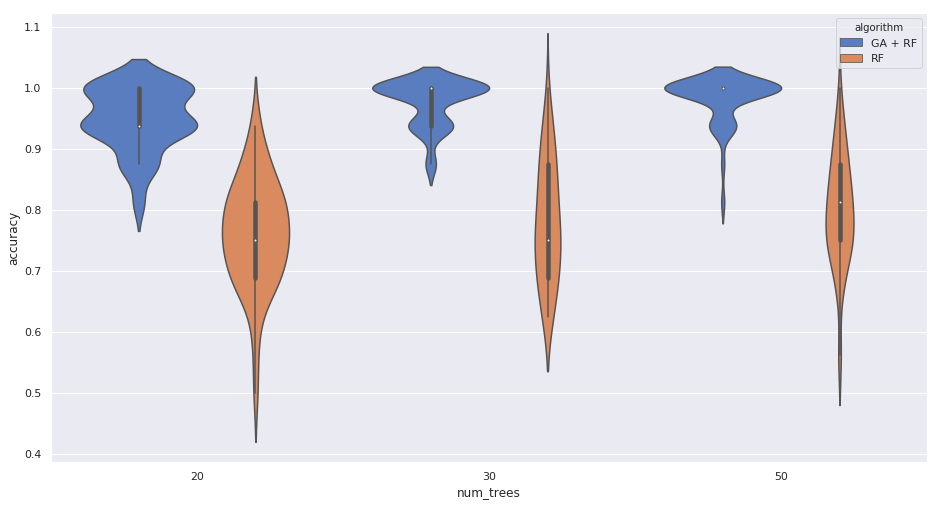

In [90]:
sns.set(rc={'figure.figsize': (15.7, 8.27) })  # set size
fig1 = violinplot(x = 'num_trees', y = 'accuracy', hue = 'algorithm', data = pd_accuracy, palette = 'muted')
fig1_save = fig1.get_figure()
fig1_save.savefig("accuracy_figure.png")

In [103]:
def save_data_and_plot(GA_result, RF_result, result_name, save_file_name, figure_size = (15.7, 8.27)):    
    pd_data = convert_to_df(GA_result,RF_result , result_name)
    # save data
    pd_data.to_csv('./figure_data/{0}.csv'.format(save_file_name))
    
    sns.set(rc={'figure.figsize': figure_size })  # set size
    fig1 = violinplot(x = 'num_trees', y = result_name, hue = 'algorithm', data = pd_data, palette = 'muted')
    fig1_save = fig1.get_figure()
    fig1_save.savefig(save_file_name)

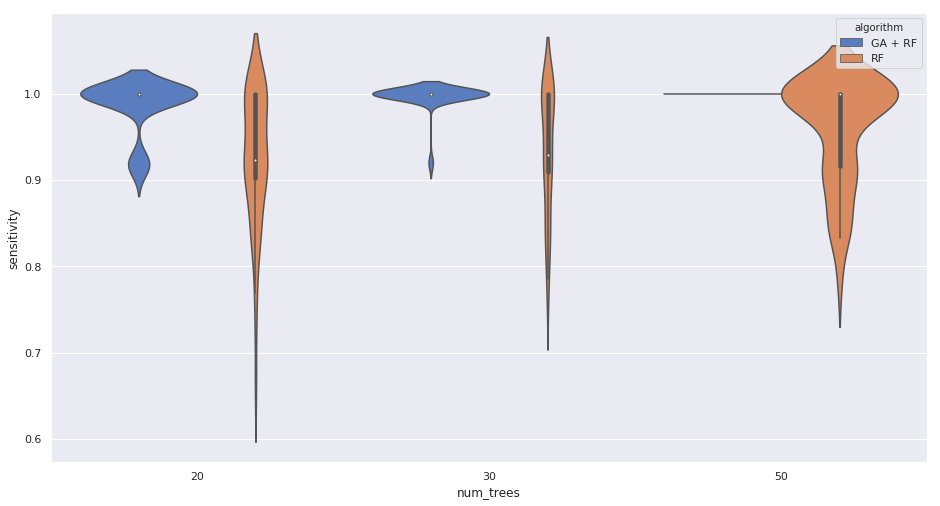

In [104]:
save_data_and_plot(GA_sensitivity_final_result,RF_sensitivity_final_result , 'sensitivity', 'sensitivity_figure.png')

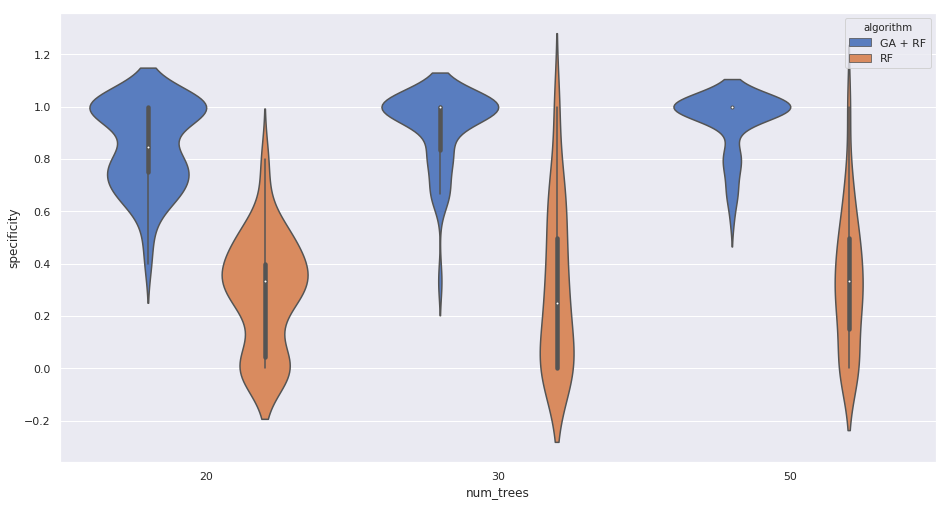

In [105]:
save_data_and_plot(GA_specificity_final_result,RF_specificity_final_result , 'specificity', 'specificity_figure.png')

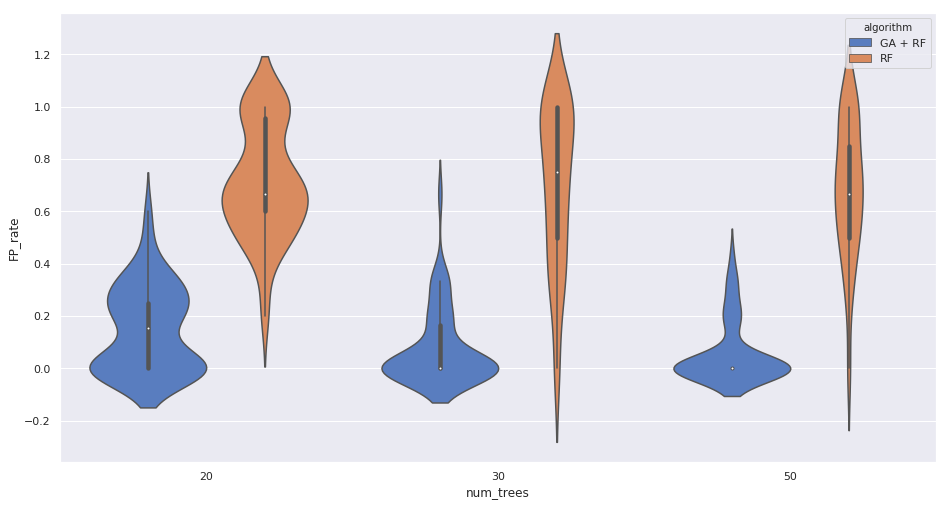

In [106]:
save_data_and_plot(GA_FP_rate_final_result,RF_FP_rate_final_result , 'FP_rate', 'FP_rate_figure.png')

In [100]:
pd_accuracy = convert_to_df(GA_accuracy_final_result,RF_accuracy_final_result , 'accuracy')
# save data
pd_accuracy.to_pickle('./figure_data/fig(1).pkl')
# load data
x = pd.read_pickle('./figure_data/fig(1).pkl')

In [101]:
pd_accuracy.to_csv('./figure_data/accuracy.csv')

In [102]:
x

,accuracy,algorithm,num_trees
0,0.8125,GA + RF,20
1,0.9375,GA + RF,20
2,1.0000,GA + RF,20
3,0.9375,GA + RF,20
4,1.0000,GA + RF,20
5,0.9375,GA + RF,20
6,1.0000,GA + RF,20
7,0.9375,GA + RF,20
8,1.0000,GA + RF,20
9,1.0000,GA + RF,20
